In [1]:
"""
NOTE: to run notebook use: venv/bin/python manage.py shell_plus --notebook
"""

import django
django.setup()

In [2]:
import os
from django.conf import settings
from DatasetAnnotator.models import Posts
from django.db.models import Q
from django.db.models import Count, Sum
from django.db.models import When, Case, Value
from django.db.models import IntegerField
import numpy as np
import pandas as pd 
from django.db.models.functions import Greatest, Coalesce

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", palette="muted", color_codes=True)
available_dbs = settings.DATABASES.keys()[1:]
PLOTS_PATH = 'Analysis/plots/'
PLOTS_FORMATS = ['.pdf', '.png']

# Threads length

In [16]:
# example: {'cooking':[1,2,1,2,5], 'webapps': [...] ....}
threads_length = dict()

for db in available_dbs:
    os.write(1, db+"\n")
    
        
    # STAGE 1: considering (only) actual threads (must sum 1 for the question)
    threads_length[db] = Posts.objects\
        .using(db)\
        .filter(posttypeid=2)\
        .values('parentid')\
        .annotate(thread_len_part=Count('parentid'))\
        .values_list('thread_len_part', flat=True)
    # adding 1 to count the question
    threads_length[db] = [x+1 for x in threads_length[db]]
    
    
    # STAGE 2: considering (only) unanswered questions
    # get ids of questions with answers
    parent_questions_ids = Posts.objects\
        .using(db)\
        .filter(posttypeid=2)\
        .values_list('parentid', flat=True)\
        .distinct()
    # count unanswered questions
    unanswered_q_count = Posts.objects\
        .using(db)\
        .filter(posttypeid=1)\
        .exclude(id__in=parent_questions_ids)\
        .count()
    
    # append unanswered q to total counting
    threads_length[db] = threads_length[db] + [1 for i in range(unanswered_q_count)]

# Thread length VS Nr threads

In [28]:
# for each distinct value in [...] count its occurence, zip the result

t_length_count = dict()

for db in available_dbs:    
    # count occurences
    bins = np.bincount(threads_length[db])
    # remove zeros from bins
    t_count = bins[np.nonzero(bins)]
    # sorted threads sizes
    t_sizes = np.unique(threads_length[db])
    
    t_length_count[db] = {
        't_count': t_count,
        't_sizes': t_sizes
    }

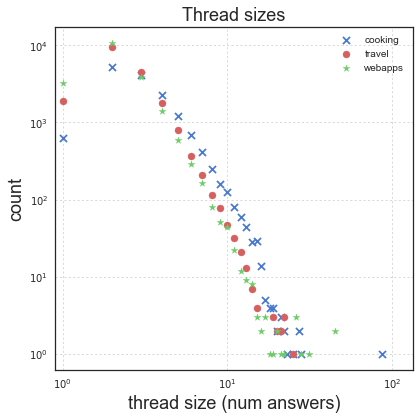

In [29]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)

ax1.scatter(x=t_length_count['cooking']['t_sizes'], 
            y=t_length_count['cooking']['t_count'], 
            label='cooking', s=50, c='b', marker='x', clip_on=False)
ax1.scatter(x=t_length_count['travel']['t_sizes'], 
            y=t_length_count['travel']['t_count'], 
            label='travel', s=50, c='r', marker='o', clip_on=False)
ax1.scatter(x=t_length_count['webapps']['t_sizes'], 
            y=t_length_count['webapps']['t_count'], 
            label='webapps', s=50, c='g', marker='*', clip_on=False)

ax1.set_xscale('log', nonposx='clip')
ax1.set_yscale('log', nonposy='clip')
plt.xlabel('thread size (num answers)', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.title('Thread sizes', fontsize=18)
ax1.set_xlim(xmin=0.9)

plt.grid(alpha=0.7, linestyle='dotted')
plt.legend()
plt.tight_layout()
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'thread_sizes' + plot_format)

# Annotations distribution

In [30]:
annotations_dist = dict()

for db in available_dbs:    
    # note: no need to remove -99 as at least one annotation is in [-1,0,1,2]
    annotations_dist[db] = Posts.objects.using(db) \
                            .filter(Q(annotatedqualityenrico__isnull=False) | \
                                Q(annotatedqualitymarit__isnull=False) | \
                                Q(annotatedqualitychristine__isnull=False) | \
                                Q(annotatedqualityhenrik__isnull=False)) \
                            .annotate(max=Greatest(
                                    Coalesce('annotatedqualityenrico', -99), 
                                    Coalesce('annotatedqualitymarit', -99),
                                    Coalesce('annotatedqualitychristine', -99),
                                    Coalesce('annotatedqualityhenrik', -99)))\
                            .values_list('max', flat=True)

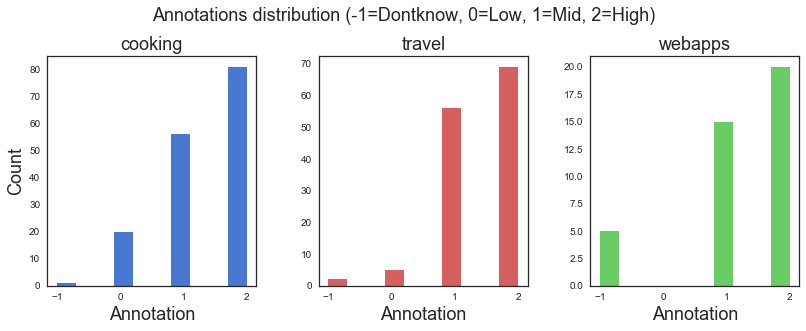

In [45]:
bins = 10
opacity = 1

plt.figure(figsize=(12,5))
plt.suptitle('Annotations distribution (-1=Dontknow, 0=Low, 1=Mid, 2=High)', fontsize=18)

ax = plt.subplot(131)
plt.hist(annotations_dist['cooking'], bins=bins, alpha=opacity, color='b', label='cooking')
plt.xlabel('Annotation', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('cooking', fontsize=18)

plt.subplot(132)
plt.hist(annotations_dist['travel'], bins=bins, alpha=opacity, color='r', label='travel')
plt.xlabel('Annotation', fontsize=18)
#plt.ylabel('Count', fontsize=18)
plt.title('travel', fontsize=18)

plt.subplot(133)
plt.hist(annotations_dist['webapps'], bins=bins, alpha=opacity, color='g', label='webapps')
plt.xlabel('Annotation', fontsize=18)
#plt.ylabel('Count', fontsize=18)
plt.title('webapps', fontsize=18)

plt.tight_layout(pad=3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'annotations_dist' + plot_format)

# Counting of questions/answers, per db

In [63]:
items_counting = {
    'whole_data': {
        'cooking': {
            'questions': -1,
            'answers': -1,
            'other': -1
        },
        'webapps': {
            'questions': -1,
            'answers': -1,
            'other': -1
        },
        'travel': {
            'questions': -1,
            'answers': -1,
            'other': -1
        }
    },
    'annotated_data': {
        'cooking': {
            'questions': -1,
            'answers': -1,
            'other': -1
        },
        'webapps': {
            'questions': -1,
            'answers': -1,
            'other': -1
        },
        'travel': {
            'questions': -1,
            'answers': -1,
            'other': -1
        }
    }
}

for db in available_dbs:
    # total nr of questions
    items_counting['whole_data'][db]['questions'] = \
        Posts.objects \
            .using(db) \
            .filter(posttypeid=1) \
            .count()

    # Total nr. of answers
    items_counting['whole_data'][db]['answers'] = \
        Posts.objects \
            .using(db) \
            .filter(posttypeid=2) \
            .count()

    # Total nr. of other posts
    items_counting['whole_data'][db]['other'] = \
        Posts.objects \
            .using(db) \
            .exclude(posttypeid=1) \
            .exclude(posttypeid=2) \
            .count()

    # counting annotated questions
    items_counting['annotated_data'][db]['questions'] = \
        Posts.objects.using(db) \
            .filter(posttypeid=1) \
            .filter(Q(annotatedqualityenrico__isnull=False) | \
                    Q(annotatedqualitymarit__isnull=False) | \
                    Q(annotatedqualitychristine__isnull=False) | \
                    Q(annotatedqualityhenrik__isnull=False)) \
            .count()

    # counting annotated answers
    items_counting['annotated_data'][db]['answers'] = \
        Posts.objects.using(db) \
            .filter(posttypeid=2) \
            .filter(Q(annotatedqualityenrico__isnull=False) | \
                    Q(annotatedqualitymarit__isnull=False) | \
                    Q(annotatedqualitychristine__isnull=False) | \
                    Q(annotatedqualityhenrik__isnull=False)) \
            .count()

    # counting annotated others
    items_counting['annotated_data'][db]['others'] = \
        Posts.objects.using(db) \
            .exclude(posttypeid=1) \
            .exclude(posttypeid=2) \
            .filter(Q(annotatedqualityenrico__isnull=False) | \
                    Q(annotatedqualitymarit__isnull=False) | \
                    Q(annotatedqualitychristine__isnull=False) | \
                    Q(annotatedqualityhenrik__isnull=False)) \
            .count()

# whole_data
questions_whole_d = [items_counting['whole_data'][db]['questions'] for db in available_dbs]
answers_whole_d = [items_counting['whole_data'][db]['answers'] for db in available_dbs]
other_whole_d = [items_counting['whole_data'][db]['other'] for db in available_dbs]

# annotated_data
questions_ann_d = [items_counting['annotated_data'][db]['questions'] for db in available_dbs]
answers_ann_d = [items_counting['annotated_data'][db]['answers'] for db in available_dbs]
other_ann_d = [items_counting['annotated_data'][db]['other'] for db in available_dbs]

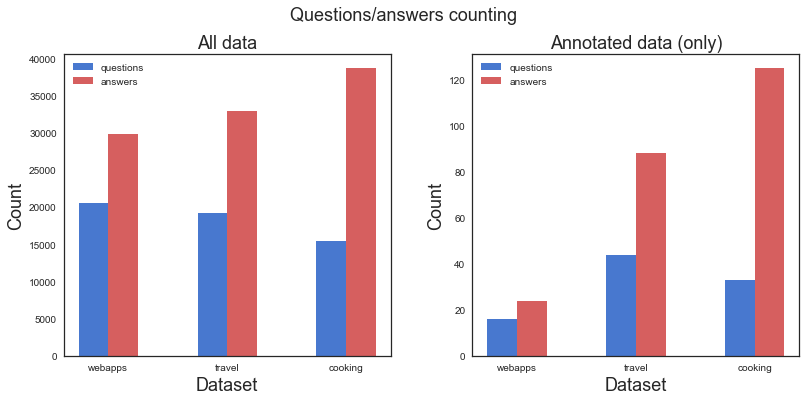

In [96]:
n_groups = 3
bar_width = 0.25
opacity = 1


# whole_data
plt.figure(figsize=(12,6))
plt.suptitle('Questions/answers counting', fontsize=18)
plt.subplot(121)
index = np.arange(n_groups)

plt.bar(index, questions_whole_d, bar_width, alpha=opacity, color='b', label='questions')
plt.bar(index + bar_width, answers_whole_d, bar_width, alpha=opacity, color='r', label='answers')
#plt.bar(index + bar_width*2, other_whole_d, bar_width, alpha=opacity, color='g', label='other')

plt.xlabel('Dataset', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('All data', fontsize=18)
plt.xticks(index + bar_width / 2, available_dbs)
plt.legend()


# annotated_data
plt.subplot(122)
index = np.arange(n_groups)

plt.bar(index, questions_ann_d, bar_width, alpha=opacity, color='b', label='questions')
plt.bar(index + bar_width, answers_ann_d, bar_width, alpha=opacity, color='r', label='answers')
#plt.bar(index + bar_width*2, other_ann_d, bar_width, alpha=opacity, color='g', label='other')

plt.xlabel('Dataset', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Annotated data (only)', fontsize=18)
plt.xticks(index + bar_width / 2, available_dbs)
plt.legend()
plt.tight_layout(pad=3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'QA_counting' + plot_format)

# Nr answers and nr questions, per user

In [155]:
# note: ids are non-negative integers
users_activity = {
    'whole_data': {
        'cooking': {
            # '1': {
            #     'nr_questions': -1,
            #     'nr_answers': -1
            # }   
        },
        'webapps': {},
        'travel': {}
    },
    'annotated_data': {
        'cooking': {},
        'webapps': {},
        'travel': {}
    }
}




for db in available_dbs:
    
    # whole_data
    
    # ex. [{'owneruserid': 17L, 'nr_questions': 13, 'nr_answers': 12}, {...}, {...}]
    whole_d_vals = Posts.objects.using(db)\
        .order_by()\
        .values('owneruserid')\
        .distinct()\
        .annotate(
            nr_questions=Sum(
            Case(When(posttypeid=1, then=Value(1)),
                 default=Value(0),
                 output_field=IntegerField())),
            nr_answers=Sum(
            Case(When(posttypeid=2, then=Value(1)),
                 default=Value(0),
                 output_field=IntegerField()))
        )
    
    data = dict()
    for val in whole_d_vals:
        # owneruserid == None if user has been deleted, -1 for wiki entries, see http://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede
        if val['owneruserid'] >= 1:
            data[val['owneruserid']] = {'nr_questions': val['nr_questions'], 'nr_answers': val['nr_answers']}
    users_activity['whole_data'][db] = data
    
    
    # ONLY annotated_data
    
    # ex. [{'owneruserid': 17L, 'nr_questions': 13, 'nr_answers': 12}, {...}, {...}]
    whole_d_vals = Posts.objects.using(db)\
        .filter(Q(annotatedqualityenrico__isnull=False) | \
                    Q(annotatedqualitymarit__isnull=False) | \
                    Q(annotatedqualitychristine__isnull=False) | \
                    Q(annotatedqualityhenrik__isnull=False)) \
        .order_by()\
        .values('owneruserid')\
        .distinct()\
        .annotate(
            nr_questions=Sum(
            Case(When(posttypeid=1, then=Value(1)),
                 default=Value(0),
                 output_field=IntegerField())),
            nr_answers=Sum(
            Case(When(posttypeid=2, then=Value(1)),
                 default=Value(0),
                 output_field=IntegerField()))
        )
    
    data = dict()
    for val in whole_d_vals:
        # owneruserid == None if user has been deleted, -1 for wiki entries, see http://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede
        if val['owneruserid'] >= 1:
            data[val['owneruserid']] = {'nr_questions': val['nr_questions'], 'nr_answers': val['nr_answers']}
    users_activity['annotated_data'][db] = data

In [ ]:
# extract: each data point is a user, x is #questions, y is #answers
whole_d_cooking = pd.DataFrame.from_dict(users_activity['whole_data']['cooking'], orient='index')
whole_d_travel = pd.DataFrame.from_dict(users_activity['whole_data']['travel'], orient='index')
whole_d_webapps = pd.DataFrame.from_dict(users_activity['whole_data']['webapps'], orient='index')


# TODO: do it also for the annotated_data

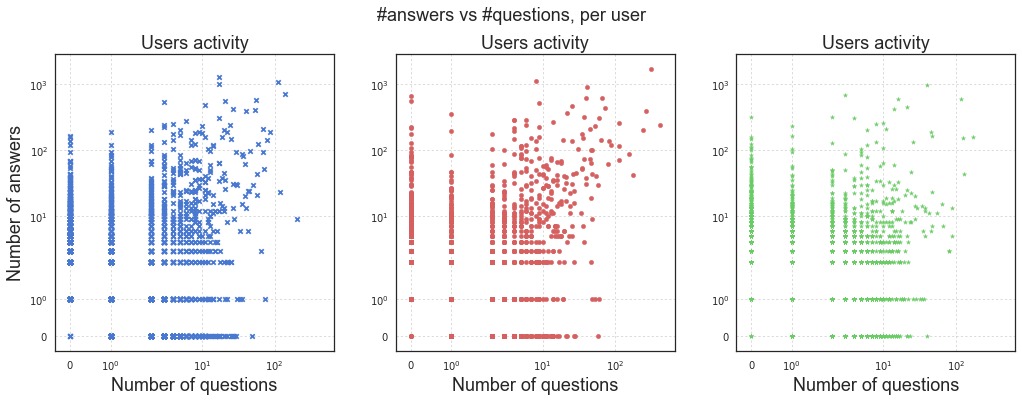

In [207]:
s=20

# scatter plots

fig = plt.figure(figsize=(15, 6))
fig.suptitle("#answers vs #questions, per user", fontsize=18)

ax1 = fig.add_subplot(131)
ax1.set_xscale('symlog', nonposx='clip')
ax1.set_yscale('symlog', nonposx='clip')
ax1.scatter(x=whole_d_cooking['nr_questions'], 
            y=whole_d_cooking['nr_answers'], 
            label='cooking', s=s, c='b', marker='x')
plt.xlabel('Number of questions', fontsize=18)
plt.ylabel('Number of answers', fontsize=18)
plt.title('Users activity', fontsize=18)
plt.grid(alpha=0.7, linestyle='dotted')

ax2 = fig.add_subplot(132, sharey=ax1, sharex=ax1)
ax2.set_xscale('symlog', nonposx='clip')
ax2.set_yscale('symlog', nonposy='clip')
ax2.scatter(x=whole_d_travel['nr_questions'], 
            y=whole_d_travel['nr_answers'], 
            label='travel', s=s, c='r', marker='o')
plt.xlabel('Number of questions', fontsize=18)
#plt.ylabel('Number of answers', fontsize=18)
plt.title('Users activity', fontsize=18)
plt.grid(alpha=0.7, linestyle='dotted')

ax3 = fig.add_subplot(133, sharey=ax1, sharex=ax1)
ax3.set_xscale('symlog', nonposx='clip')
ax3.set_yscale('symlog', nonposy='clip')
ax3.scatter(x=whole_d_webapps['nr_questions'], 
            y=whole_d_webapps['nr_answers'], 
            label='webapps', s=s, c='g', marker='*')
plt.xlabel('Number of questions', fontsize=18)
#plt.ylabel('Number of answers', fontsize=18)
plt.title('Users activity', fontsize=18)
plt.grid(alpha=0.7, linestyle='dotted')

plt.tight_layout(pad=3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'nr_answers_VS_nr_questions_scatter' + plot_format)

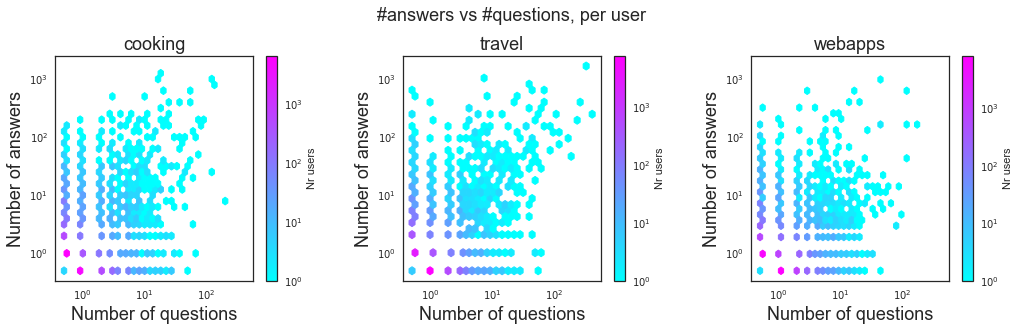

In [203]:
# hex bins


fig = plt.figure(figsize=(15, 5))
fig.suptitle("#answers vs #questions, per user", fontsize=18)

ax1 = fig.add_subplot(131)
hb = ax1.hexbin(x=whole_d_cooking['nr_questions'].replace(0, 0.5), 
                y=whole_d_cooking['nr_answers'].replace(0, 0.5), 
                xscale='log', 
                yscale='log',
                norm=matplotlib.colors.LogNorm(),
                label='cooking',
                cmap='cool',
                gridsize=30,
                mincnt=1)
#ax1.axis([0.5, whole_d_cooking['nr_questions'].max(), 0.5, whole_d_cooking['nr_answers'].max()])
cb = fig.colorbar(hb, ax=ax1)
cb.set_label('Nr users')
plt.xlabel('Number of questions', fontsize=18)
plt.ylabel('Number of answers', fontsize=18)
plt.title('cooking', fontsize=18)


ax2 = fig.add_subplot(132,  sharey=ax1, sharex=ax1)
hb = ax2.hexbin(x=whole_d_travel['nr_questions'].replace(0, 0.5), 
                y=whole_d_travel['nr_answers'].replace(0, 0.5), 
                xscale='log', 
                yscale='log',
                norm=matplotlib.colors.LogNorm(),
                label='cooking',
                cmap='cool',
                gridsize=30,
                mincnt=1)
#ax2.axis([0.5, whole_d_cooking['nr_questions'].max(), 0.5, whole_d_cooking['nr_answers'].max()])
cb = fig.colorbar(hb, ax=ax2)
cb.set_label('Nr users')
plt.xlabel('Number of questions', fontsize=18)
plt.ylabel('Number of answers', fontsize=18)
plt.title('travel', fontsize=18)


ax3 = fig.add_subplot(133,  sharey=ax1, sharex=ax1)
hb = ax3.hexbin(x=whole_d_webapps['nr_questions'].replace(0, 0.5), 
                y=whole_d_webapps['nr_answers'].replace(0, 0.5), 
                xscale='log', 
                yscale='log',
                norm=matplotlib.colors.LogNorm(),
                label='cooking',
                cmap='cool',
                gridsize=30,
                mincnt=1)
#ax3.axis([0.5, whole_d_cooking['nr_questions'].max(), 0.5, whole_d_cooking['nr_answers'].max()])
cb = fig.colorbar(hb, ax=ax3)
cb.set_label('Nr users')
plt.xlabel('Number of questions', fontsize=18)
plt.ylabel('Number of answers', fontsize=18)
plt.title('webapps', fontsize=18)


plt.tight_layout(pad=3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'nr_answers_VS_nr_questions_2dhist' + plot_format)